In [39]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [40]:
df = pd.read_csv("../data/raw/raw.csv")
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Columns: 32 entries, hotel to reservation_status_date
dtypes: float64(4), int64(16), object(12)
memory usage: 29.1+ MB


# Cleaning data

Vamos a estudiar los valores nulos presentes en el dataset y decidir cómo tratar cada uno de ellos.

In [41]:
columns_with_null_values = df.columns[df.isnull().any()].tolist()
df.isnull().sum()[columns_with_null_values]

children         4
country        488
agent        16340
company     112593
dtype: int64

Vemos que hay 4 columnas que tienen, al menos, un valor nulo.

- Las columnas 'agent' y 'company' tienen una gran cantidad de valores nulos. Dado que estas columnas no ofrecen información más allá de identificadores tanto de empresa como de agente, optamos por eliminarlas del dataset.
- La columna 'country' tiene 488 valores nulos. Esto se puede deber a problemas derivados de los formularios o al anonimato. En cualquier caso, optamos por sustituir con el valor "Unknown" simbolizando un origen desconocido.
- La columna 'children' tiene únicamente 4 valores nulos. Dado la poca cantidad de filas con respecto al total, optamos por eliminarlas.

Por otro lado, hay dos columnas que, dada su descripción, podrían ser características íntimamente relacionadas con la variable de salida: 'reservation_status' y 'reservation_status_date'. Dado que 'reservation_status' representa el estado final de la reserva, esta es una información que solo se obtiene tras conocer la cancelación o no cancelación de la reserva. Por tanto, mantenerla supondría un data leakeage o fuga de datos (prácticamente sería entrenar con la variable de salida). Las quitaremos también.

In [42]:
print(f"Before: {len(df.columns.tolist())} columns and {len(df)} rows.")

# remove not wanted columns
df = df.drop(columns=["agent", "company", "reservation_status", "reservation_status_date"])

# fill null values from 'country' column with 'Unknown'
df["country"] = df["country"].fillna("Unknown")

# remove rows (axis=0) with null values (only belongs to 'children' null values)
df = df.dropna(axis=0)

print(f"After: {len(df.columns.tolist())} columns and {len(df)} rows.")

Before: 32 columns and 119390 rows.
After: 28 columns and 119386 rows.


# Feature Engineering

Dado el alto número de variables y sus descripciones, vamos a estudiar cada una de ellas para ver su relevancia y las posibles transformaciones que podrían admitir.

## Posibles tipos de huésped

En el dataset tenemos columnas que definen los tres tipos posibles de huésped: 'adults', 'children' y 'babies'. En principio, podríamos pensar que la presencia de niños o bebés podría aumentar la probabilidad de cancelación, por la incertidumbre que rodea siempre a los más pequeños. Estidemos sus valores y veamos las correlaciones.



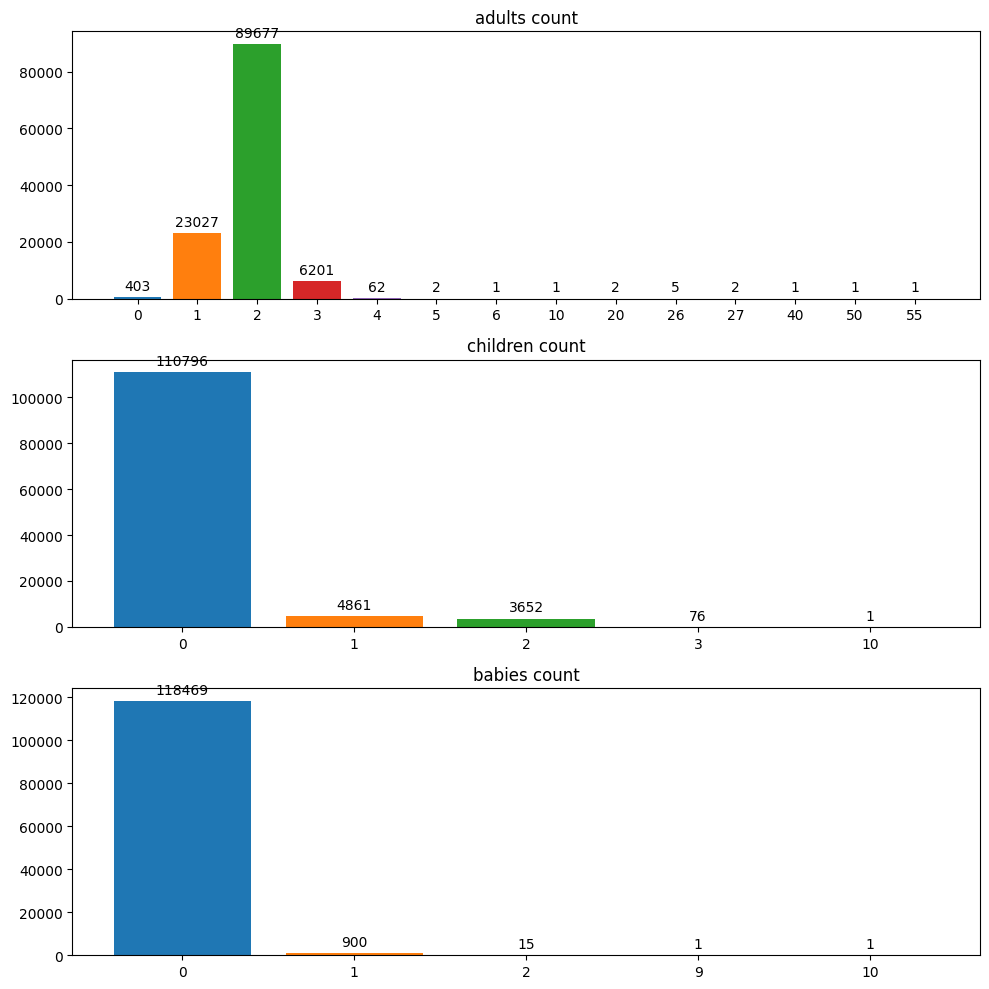

In [43]:
_df = df[["children", "babies", "adults", "is_canceled"]].copy()

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

multiplier = 0
width = 0.25

for i, guest_type in enumerate(["adults", "children", "babies"]):
    counts = _df[guest_type].value_counts(sort=False).sort_index()
    
    x_values = np.arange(len(counts))
    for x, size in zip(x_values, counts.values):
        offset = width + multiplier
        rects = axes[i].bar(str(x + offset), size)
        axes[i].bar_label(rects, padding=3)
        multiplier += 1

    axes[i].set_xticks(x_values, counts.index.astype(int).astype(str).tolist())
    axes[i].set_title(f"{guest_type} count")

fig.tight_layout()


De este gráfico podemos sacar varias conclusiones:
1. Para los tres tipos hay valores que podemos considerar outliers. Por ejemplo, reservas con 55 adultos o 10 niños.
2. Hay reservas con 0 adultos, algo que en principio no debería ser posible.
3. ¿Puede darse el caso de que haya reservas con valor 0 para los tres tipos? Es decir, ¿podría haber reservas con 0 invitados?

Para el caso (1) podríamos aplicar capping para dejar el peso del significado de "es una reserva de un grupo de personas" en la variable "customer_type", sin embargo, vamos a dejarlo tal cuál está para no hacerlo demasiado complejo. Para el caso (2) y el caso (3) merece la pena profundizar un poco más.

En principio, no es lo común que haya habitaciones reservadas para menores de edad. Pero legalmente es posible en algunos escenarios, siempre y cuando se presente autorización formal por parte de un adulto. Por tanto, dado que no tiene por qué ser un error, debemos ver si es representativo para decidir qué hacer con los datos.

In [44]:
_df["total_guests"] = _df["adults"] + _df["children"] + _df["babies"]
zero_guests_df = _df[_df["total_guests"] == 0]
print(f"Total rows with zero guests:", len(zero_guests_df))

print(_df[_df["adults"] == 0]["children"].value_counts())
print(_df[_df["adults"] == 0]["babies"].value_counts())

Total rows with zero guests: 180
children
2.0    208
0.0    180
3.0     11
1.0      4
Name: count, dtype: int64
babies
0    400
1      3
Name: count, dtype: int64


Para los niños, vemos que hay reservas sin adultos que van desde 0 a 3 niños, siendo 0 y 2 la inmensa mayoría. Para este caso, decidimos dejarlo tal cual ya que son bastantes filas. Otra decisión que podríamos tomar es imputar el valor de adultos a 2, que es el más frecuente. Dado que legalmente es posible, vamos a dejarlo como está. Para el caso de bebés es distinto, ya que no puede haber reservas sin adultos para bebés. En ese caso, solo hay 3 filas, por lo que las eliminaremos.

In [45]:
df["total_guests"] = df["adults"] + df["children"] + df["babies"]

no_adults_with_babies_indexes = df[(df["adults"] == 0) & (df["babies"] > 0)].index

df = df.drop(index=no_adults_with_babies_indexes)

Con las reservas sin huéspedes podemos tomar dos caminos: o bien imputarlas a la reserva más común (dos adultos, sin niños ni bebés) o eliminarlas. Dado que son bastantes columnas y la reserva más común es bastante más representativa que el resto, decidimos imputarla.

In [46]:
print(f"Rows with 2 adults before:", len(df[df["adults"] == 2]))

df.loc[(df["total_guests"] == 0) & (df["children"] == 0) & (df["babies"] == 0), "adults"] = 2

print(f"Rows with 2 adults after:", len(df[df["adults"] == 2]))

Rows with 2 adults before: 89677
Rows with 2 adults after: 89857


Terminamos eliminado la columna "total_guests" ya que está correlacionada con las otras.

In [47]:
df = df.drop(columns="total_guests")

## Habitación esperada vs. habitación asignada

Las columnas 'reserved_room_type' y 'assigned_room_type' es de las variables más confusas del dataset. Un cambio en la habitación esperada podría ser un motivo de cancelación debido a la insatisfacción producida en el cliente por recibir algo que en principio no era esperado. Dado que no tenemos información sobre qué significa cada uno de los tipos de habitaciones, no podemos establecer si la habitación de tipo A es mejor que la habitación de tipo B o viceversa.

Otro problema derivado de desconocer esta información es que no sabemos cuándo se conoce, por parte del cliente, esta asignación. Si el cliente la conoce con suficiente antelación, en principio, daría una mayor posibilidad al cliente de cancelación debido a la capacidad de maniobra. Si esta asignación es conocida directamente en el hotel, una vez se hace el check-in, imaginamos que la capacidad de maniobra del cliente se ve reducida, por lo que la probabilidad de cancelación es menor.

Vamos a definir una nueva columna, llamada 'room_changed', con un valor binario que define si la habitación asignada es distinta a la reservada. Asumimos que esta información la conoce el cliente previamente al check-in y, por tanto, es relevante para la cancelación.

Dado que son columnas categóricas, es necesario codificarla de alguna forma para medir la correlación. Usamos get_dummies de pandas para generar la codificación de One Hot.

In [48]:
_df = pd.get_dummies(df[["reserved_room_type", "assigned_room_type"]])

print("Columns created for reserved room types:", _df.filter(like="reserved_").columns.__len__())
print("Columns created for assigned room types:", _df.filter(like="assigned_").columns.__len__())

_df["room_changed"] = (df["reserved_room_type"] != df["assigned_room_type"]).astype(int)
_df["is_canceled"] = df["is_canceled"]
_df.corr()["is_canceled"].abs().sort_values(ascending=False)[:5]

Columns created for reserved room types: 10
Columns created for assigned room types: 12


is_canceled             1.000000
room_changed            0.247766
assigned_room_type_A    0.197258
assigned_room_type_D    0.128020
reserved_room_type_A    0.068717
Name: is_canceled, dtype: float64

Vemos que esta nueva variable creada tiene mayor correlación con la salida que cualquiera de la otras. Además, es más fácilmente interpretable que el resto y evitamos añadir 22 columnas al dataset. Por tanto, nos quedaremos con esta nueva columna y eliminarelos el resto.

In [49]:
df["room_changed"] = (df["reserved_room_type"] != df["assigned_room_type"]).astype(int)

df = df.drop(columns=["reserved_room_type", "assigned_room_type"])

## Influencia del origen

Vamos a estudiar la influencia del origen de los huéspedes en la cancelación de la reserva.

In [50]:
cancelations_by_country = df.groupby('country')['is_canceled'].agg(total='count', canceled='sum').reset_index()
cancelations_by_country['cancel_ratio'] = (cancelations_by_country['canceled'] / cancelations_by_country['total'])
cancelations_by_country = cancelations_by_country.sort_values(by='cancel_ratio', ascending=False)

cancelations_by_country.head(10)

,country,total,canceled,cancel_ratio
16,BEN,3,3,1.0
55,FJI,1,1,1.0
118,MYT,2,2,1.0
88,KHM,2,2,1.0
83,JEY,8,8,1.0
74,IMN,2,2,1.0
70,HND,1,1,1.0
122,NIC,1,1,1.0
167,UMI,1,1,1.0
173,VGB,1,1,1.0


Vemos que la mayoría de países de origen con un ratio de cancelación muy alto tiene un número total de reservas muy reducido, por lo que no sería conveniente tomar decisiones en base a este ratio debiod a la poca representación y al sesgo.

Vamos a visualizar en un mapa estos valores para ver si existe alguna tendencia en función de la localización. Los valores de la columna 'country' contiene los códigos de los países en un formato ISO (estándar), por lo que algunas funciones lo entiendes y es muy sencillo plotearlo. 

In [51]:
fig = px.choropleth(
    cancelations_by_country,
    locations="country",
    color="cancel_ratio",
    hover_name="country",
    color_continuous_scale="Reds",
    projection="natural earth",
    title="Cancel ratio by country"
)

fig.show()

Vemos como no parece existir ninguna tendencia en concreto debido exclusivamente a la geografía ni a la lejanía/cercanía.

Dado que es una columna categórica de muchos valores posibles, mantendremos los países con mayor representación de reservas (top-20) y agruparemos el resto, reduciendo el número de columnas en una gran cantidad. Además, minimizamos la influencia de países subrepresentados.

In [52]:
print("Different countries before:", df["country"].unique().__len__())

top_20_countries = df["country"].value_counts().head(20).index.tolist()
print("Top 20 countries:", top_20_countries)
df['country'] = df['country'].apply(lambda x: x if x in top_20_countries else 'Other')

print("Different countries after:", df["country"].unique().__len__())

Different countries before: 178
Top 20 countries: ['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE', 'CN', 'AUT', 'SWE', 'CHN', 'POL', 'ISR', 'RUS', 'NOR']
Different countries after: 21


## Duración de la estancia

En muchos casos, la duración total de la estancia puede ser un aspecto relevante a la hora de calcular la probabilidad de cancelación. En principio, podemos imaginar que es más probable cancelar una estancia corta que una estancia de mayor duración (menor planificación, menor dinero invertido).

No existe en el dataset una columna que indique, directamente, la duración de la estancia. Por ello, vamos a utilizar 'stays_in_weekend_nights' y 'stays_in_week_nights' para crear una nueva columna 'total_nights'. Dado que además estas dos columnas nos ofrecen ninguna información extra, las eliminaremos.

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13388\2225566566.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0, 0.5, 'Cancel ratio (%)')

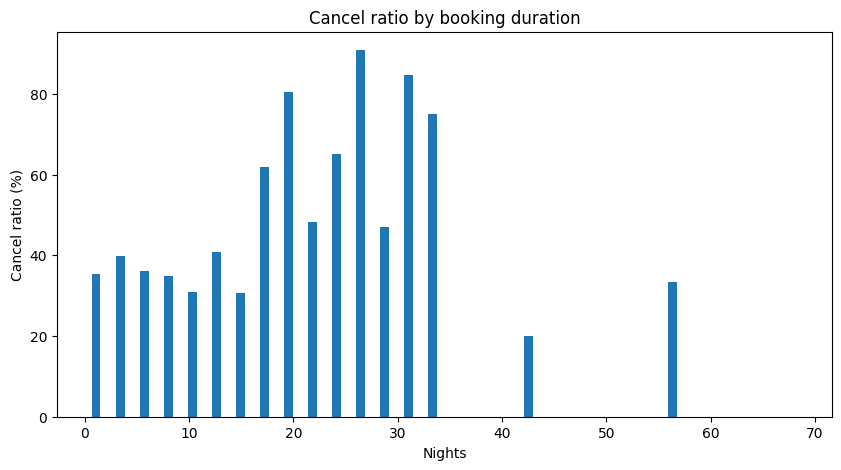

In [53]:
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

cuts = pd.cut(df["total_nights"], bins=30)

cuts = pd.concat((pd.DataFrame(cuts), df["is_canceled"]), axis=1)

rate_by_bins = cuts.groupby('total_nights')['is_canceled'].agg(total="count", canceled="sum")
rate_by_bins["cancel_ratio"] = rate_by_bins["canceled"] / rate_by_bins["total"]
rate_by_bins = rate_by_bins.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([i.mid for i in rate_by_bins.index], rate_by_bins["cancel_ratio"]*100)
ax.set_title("Cancel ratio by booking duration")
ax.set_xlabel("Nights")
ax.set_ylabel("Cancel ratio (%)")

Parece que la tendencia a la cancelación crece para estancias medianamente duraderas, de 2 semanas en adelante. Para estancias superiores a un mes, la muestra es tan pequeña (máximo 5 reservas) que no se deberían tomar conclusiones. Por tanto, tras ver la distribución, decidimos agrupar en los siguientes grupos:
- Estancia de 0 noches - relacionada con estancias de descanso.
- Estancia de 1 noche - generalmente por motivos profesionales o estancias puente entre un destino y otro.
- Estancia de 2 a 4 noches - vacaciones fugaces por fines de semana o puentes.
- Estancia de 5 a 9 noches - vacaciones algo más extendidas.
- Estancia de 10 a 21 noches - vacaciones muy extensas (entre 1.5 y 3 semanas).
- Estancia de más de 21 noches - vacaciones extremadamente extensas.

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13388\3122434525.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13388\3122434525.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0, 0.5, 'Cancel ratio (%)')

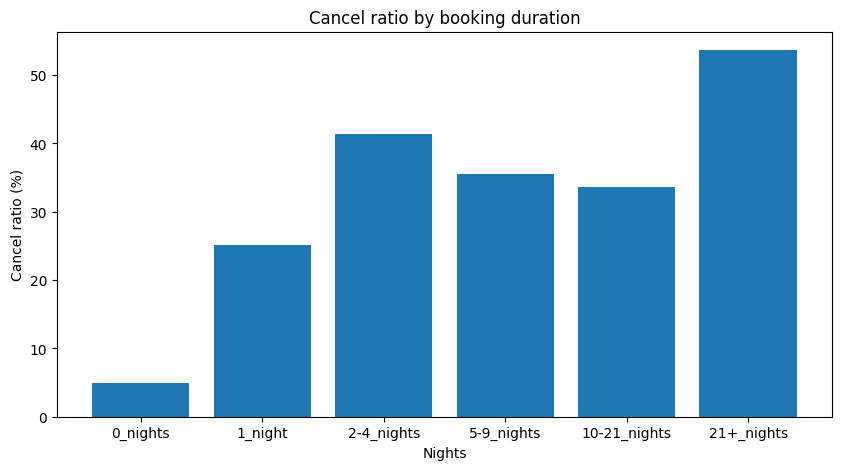

In [54]:
_df = df[["total_nights", "is_canceled"]]
bins = [0, 1, 2, 5, 10, 22, df["total_nights"].max()+1]
labels = ["0_nights", "1_night", "2-4_nights", "5-9_nights", "10-21_nights", "21+_nights"]
cuts, bins_ = pd.cut(_df["total_nights"], bins=bins, labels=labels, right=False, include_lowest=True, retbins=True)

_df["total_nights_bins"] = cuts

rate_by_bins = _df.groupby('total_nights_bins')['is_canceled'].agg(total="count", canceled="sum")
rate_by_bins["cancel_ratio"] = rate_by_bins["canceled"] / rate_by_bins["total"]
rate_by_bins = rate_by_bins.fillna(0)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(rate_by_bins.index, rate_by_bins["cancel_ratio"]*100)
ax.set_title("Cancel ratio by booking duration")
ax.set_xlabel("Nights")
ax.set_ylabel("Cancel ratio (%)")

Vemos que hay bastante diferencia entre estancias de 0 noches y 1 noche con respecto al esto. Categorizando, conseguimos extraer más información de la que se tendría con el valor continuo. Añadimos la columna 'stay_period' y eliminamos 'total_nights', 'stays_in_weekend_nights' y 'stays_in_week_nights'. 

In [55]:
df["stay_period"] = _df["total_nights_bins"].values

df = df.drop(columns=["total_nights", "stays_in_weekend_nights", "stays_in_week_nights"])

## Variables relacionadas con la fecha de llegada

Hay 4 columnas que hacen referencia a la fecha de inicio de la estancia: 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month' y 'arrival_date_week_number'.

Para utilizar la variable 'arrival_date_year' sería necesario realizar un One Hot Encoding. Sin embargo, dado que estamos en 2025 y los registros son entre los años 2015 y 2017, no vamos a tener en cuenta esta columna. No tiene sentido tenerla en cuenta ya que el objetivo no es hacer estudios de mercado, sino predecir la probabilidad de cancelación. En el caso de estudio de mercado, si tendría sentido mantenerla ya que ofrecería información sobre las tendencias económicas, pero eso va mucho más allá del objetivo de este ejercicio.

Con 'arrival_date_week_number' y 'arrival_date_month' tenemos dos variables que sitúan la reserva en un momento concreto del año. Dado que no podemos situar en alta/media/baja temporada, situaremos en función del cuatrimestre anual (quarter).

'arrival_date_day_of_month' solo tiene sentido si la utilizamos conjuntamente con el 'arrival_date_month'. Podemos utilizarla para crear una nueva columna binaria 'is_arrival_date_at_weekend' que define si la llegada es en fin de semana o no, algo que puede ofrecer mayor valor a la predicción de la cancelación.

In [56]:
arrival_date = df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str)
arrival_date = pd.to_datetime(arrival_date, errors='coerce')

df["is_arrival_at_weekend"] = arrival_date.dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
print(df["is_arrival_at_weekend"].value_counts())

df["arrival_quarter"] = arrival_date.dt.quarter.apply(lambda x: f"Q{x}")
print(df["arrival_quarter"].value_counts())

is_arrival_at_weekend
0    87187
1    32196
Name: count, dtype: int64
arrival_quarter
Q3    37042
Q2    33818
Q4    24732
Q1    23791
Name: count, dtype: int64


In [57]:
df = df.drop(columns=["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", "arrival_date_week_number"])

## Relevancia de los días en lista de espera

La presencia o no en lista de espera pudiera parecer un indicio de que el cliente desea la reserva en ese hotel en específico. Vamos a estudiar esta variable, al igual que hicimos con la duración de la estancia.

In [58]:
_df = df[["days_in_waiting_list", "is_canceled"]]
_df["was_in_waiting_list"] = (_df["days_in_waiting_list"] > 0).astype(int)

_df.corr()["is_canceled"]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13388\3895604206.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



days_in_waiting_list    0.054194
is_canceled             1.000000
was_in_waiting_list     0.099044
Name: is_canceled, dtype: float64

El hecho de que el cliente estuviera presente en lista de espera tiene, en principio, mayor relevancia que los días en lista de espera. Vamos a analizarlo.

In [59]:
print(f"Bookings with wait list: {_df["was_in_waiting_list"].mean()*100:.2f}%")

_df[_df["was_in_waiting_list"].astype(bool)]["days_in_waiting_list"].describe()

Bookings with wait list: 3.10%


count    3698.000000
mean       74.938345
std        67.482918
min         1.000000
25%        38.000000
50%        56.000000
75%        91.000000
max       391.000000
Name: days_in_waiting_list, dtype: float64

In [60]:
_df.groupby('was_in_waiting_list')['is_canceled'].mean() * 100

was_in_waiting_list
0    36.184466
1    63.791239
Name: is_canceled, dtype: float64

El 76% de los clientes que estuvieron en lista de espera cancelaron la reserva. Vamos a estudiar el porcentaje de cancelación en función del período en lista de espera.

C:\Users\Daniel\AppData\Local\Temp\ipykernel_13388\1050160080.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0, 0.5, 'Cancel ratio (%)')

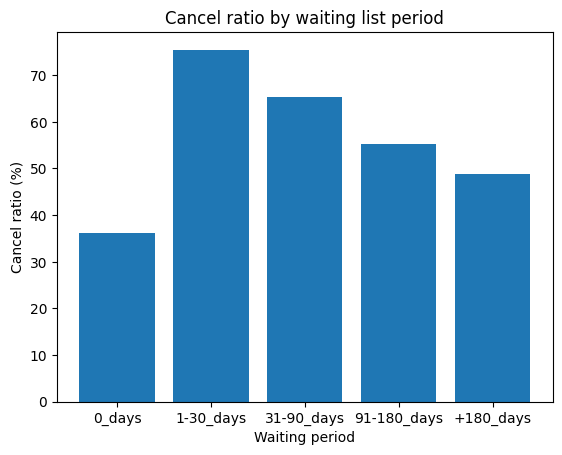

In [61]:
bins = [0, 1, 31, 91, 181, df['days_in_waiting_list'].max() + 1]
labels = ['0_days', '1-30_days', '31-90_days', '91-180_days', '+180_days']
wait_time_bins = pd.cut(
    df['days_in_waiting_list'], 
    bins=bins, 
    labels=labels, 
    right=False,
    include_lowest=True
)

cancel_ratio_by_waiting_period = df.groupby(wait_time_bins)['is_canceled'].mean() * 100

fig, ax = plt.subplots()
rects = ax.bar(cancel_ratio_by_waiting_period.index, cancel_ratio_by_waiting_period.values)
ax.set_title("Cancel ratio by waiting list period")
ax.set_xlabel("Waiting period")
ax.set_ylabel("Cancel ratio (%)")

Vemos como el porcentaje de cancelación es bajo cuando no ha estado en lista de espera. En cambio, cuando sí que ha estado en lista de espera, el pico de cancelación sucede cuando el tiempo es menor. Conforme el tiempo de espera aumenta, el porcentaje de cancelación disminuye. Esto refuerza la idea inicial propuesta.

Dejaremos esta característica y eliminaremos la original 'days_in_waiting_list".

In [62]:
df["waiting_list_period"] = wait_time_bins
df = df.drop(columns="days_in_waiting_list")

## Precio promedio

In [63]:
df[df["adr"] < 0].info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 14969 to 14969
Columns: 24 entries, hotel to waiting_list_period
dtypes: category(2), float64(2), int64(12), object(8)
memory usage: 618.0+ bytes


Hay un valor cuyo valor de "adr" es negativo. Lo eliminamos debido a que debe ser un error.

In [64]:
df = df.drop(index=df[df["adr"] < 0].index)

También existen muchos valores de "adr" iguales a 0, pero decidimos dejarlos tal cual para no influir en los valores reales.

## Ratio de cancelación

Tenemos dos variables referidas a relaciones previas entre cliente y huésped: 'previous_cancellations' y 'previous_bookings_not_canceled'. Vamos a fusionarlas en una única variable 'guest_cancel_ratio' que ofrece la misma información en una única columna y normalziada entre cero y uno.

In [65]:
df["guest_cancel_ratio"] = (df["previous_cancellations"] / (df["previous_cancellations"] + df["previous_bookings_not_canceled"])).fillna(0)

df = df.drop(columns=["previous_cancellations", "previous_bookings_not_canceled"])

## Otra columnas categóricas

Vamos a ver el resto de variables categóricas.

### Tipo de hotel

Text(0.5, 1.0, 'Hotel type distribution')

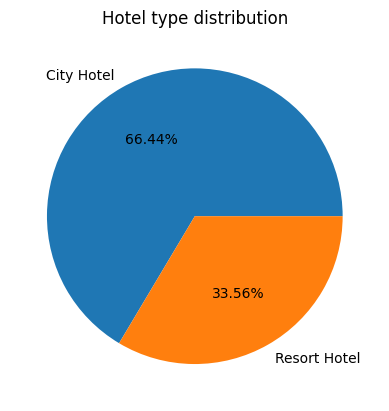

In [66]:
counts = df["hotel"].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.pie(counts.values, labels=counts.index, autopct="%1.2f%%")
ax.set_title("Hotel type distribution")

### Tipos de régimen de comidas

Text(0.5, 1.0, 'Meal type distribution')

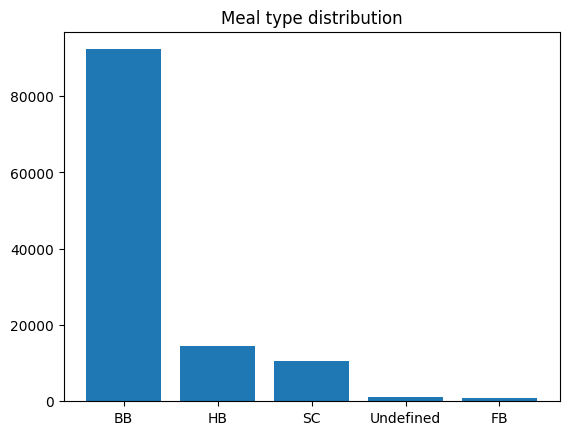

In [67]:
counts = df["meal"].value_counts(normalize=False)

fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title("Meal type distribution")

### Segmentos de mercado

Text(0.5, 1.0, 'Market segments distribution')

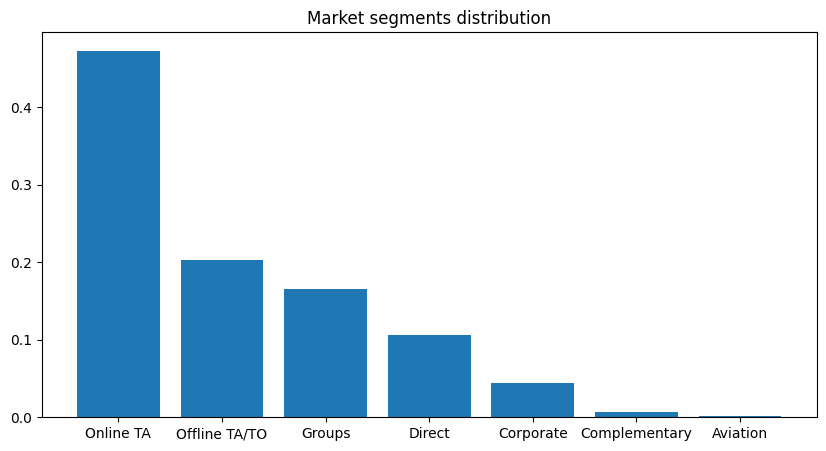

In [68]:
counts = df["market_segment"].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(counts.index, counts.values)
ax.set_title("Market segments distribution")

### Canales de distribución

Text(0.5, 1.0, 'Distribution channels')

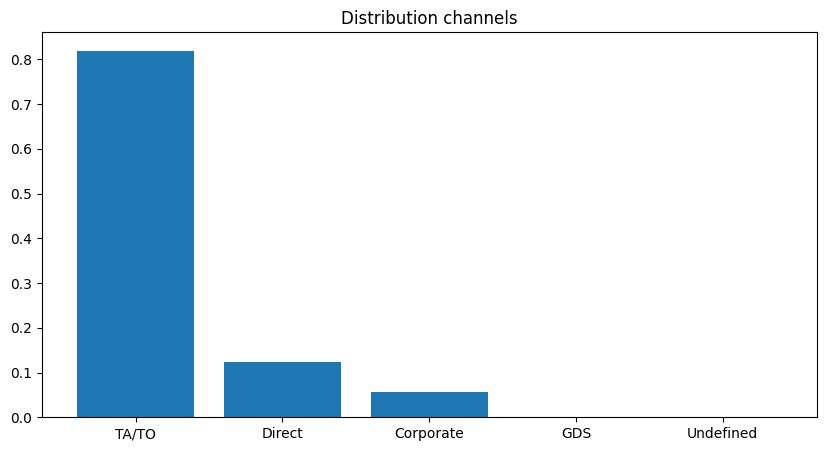

In [69]:
counts = df["distribution_channel"].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(counts.index, counts.values)
ax.set_title("Distribution channels")

### Tipos de depósito

Text(0.5, 1.0, 'Deposit type distribution')

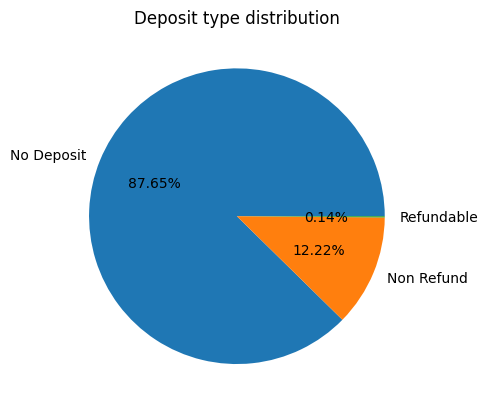

In [70]:
counts = df["deposit_type"].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.pie(counts.values, labels=counts.index, autopct="%1.2f%%")
ax.set_title("Deposit type distribution")

### Tipo de cliente

Text(0.5, 1.0, 'Customer type distribution')

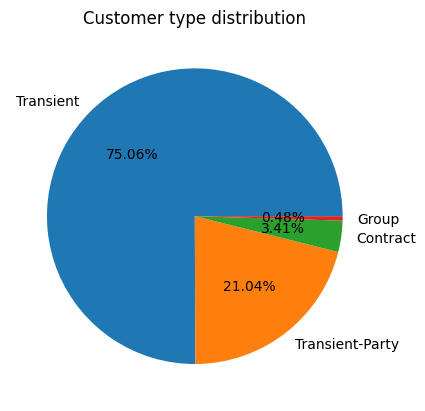

In [71]:
counts = df["customer_type"].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.pie(counts.values, labels=counts.index, autopct="%1.2f%%")
ax.set_title("Customer type distribution")

Algunas de estas columnas tienen un valor "Undefined". En principio, podrían ser valores erróneos pero, dada la naturaleza de las variables donde aparece, pudiera tener sentido tener un valor de este tipo. Por ejemplo, para 'distribution_channel' es posible que el cliente no encaje en ninguna de las categorías propuestas, por lo que se crea un tipo indefinido.

## Resumen de variables finales

A continuación se propone un resumen de todo lo realizado:

- Limpieza de valores nulos:
    - Eliminar columnas "agent" y "company" que tenían un alto porcentaje de valores nulos.
    - Eliminar 4 filas con valores nulos en la columna "children".
    - Rellenar con "Unknown" los valores nulos en la columna "country".

- Columnas eliminadas:
    - agent (nulos)
    - company (nulos)
    - reservation_status (data leakeage)
    - reservation_status_date (data leakeage)
    - reserved_room_type (FE)
    - assigned_room_type (FE)
    - stays_in_weekend_nights (FE)
    - stays_in_week_nights (FE)
    - arrival_date_year (FE)
    - arrival_date_month (FE)
    - arrival_date_day_of_month (FE)
    - arrival_date_week_number (FE)
    - days_in_waiting_list (FE)
    - previous_cancellations (FE)
    - previous_bookings_not_canceled (FE)

- Nuevas características
    - room_changed: flag binaria para definir si la habitación asignada es igual a la reservada (0) o no (1). A partir de reserved_room_type y assigned_room_type.
    - stay_period: categorización de la suma de stays_in_weekend_nights y stays_in_week_nights: "0_nights", "1_night", "2-4_nights", "5-9_nights", "10-21_nights", "21+_nights".
    - is_arrival_at_weekend: flag binaria para definir si la llegada es en fin de semana (1) o entre semana (0). A partir de las columnas "arrival_date_ ..."
    - arrival_quarter: Categorización de la fecha de llegada: de Q1 a Q4. A partir de las columnas "arrival_date_ ..."
    - waiting_list_period: categorización de days_in_waiting_list: '0_days', '1-30_days', '31-90_days', '91-180_days', '+180_days'.
    - guest_cancel_ratio: ratio entre 0 y 1 que define el ratio de cancelación de un cliente que ya ha hecho una reserva previa.

- Otros cambios:
    - Las reservas con 0 huéspedes (adultos + niños + bebés = 0) se han imputado a la moda (2 adultos sin niños).
    - Las reservas con algún bebé pero sin adultos (adults == 0 & babies > 0) se han eliminado.
    - Se ha hecho una recategorización de la columna "country" agrupando los países fuera del TOP-20 (en base a la frecuencia en el dataset) en un único grupo "Other".
    - Se ha eliminado las filas con un "adr" negativo.

In [72]:
df.to_csv("../data/cleaned/cleaned.csv")